# 라이브러리

In [6]:
# install.packages("readxl")
# install.packages("lm.beta")
# install.packages("changepoint")
# install.packages("quantmod")
# install.packages("forecast")
# install.packages("lmtest")
# install.packages("sarima")
# install.packages("randomForest")
# install.packages("ggplot2")

library(readxl)
library(lm.beta)
library(changepoint)
library(quantmod)
library(forecast)
library(lmtest)
library(sarima)
library(randomForest)
library(ggplot2)
library(gridExtra)

#setwd("D:/DSoft")

Warning message:
"package 'readxl' was built under R version 3.6.2"Warning message:
"package 'changepoint' was built under R version 3.6.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.
Warning message:
"package 'quantmod' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.2"Loading required package: TTR
Warning message:
"package 'TTR' was built under R version 3.6.2"Registered S3 method overwritten by 'quantmod':
  method            from
  as.z

# 테스트 데이터 가져오기

In [3]:
k = 6  ## 한 파일에 여러 데이터셋 들어있을 경우 열넘버로 지정. 데이터셋 하나면 k=1

In [83]:
# excel.xlsx 파일인 경우
excelData = read_excel("example10.xlsx", col_types = "numeric")[,k]
excelData_title = names(excelData)
excelData = na.omit(excelData)[[1]] # 1차원 벡터 or 리스트 형태

In [4]:
# csv 파일인 경우
excelData = read.csv("example10.csv", header = TRUE)
excelData_title = colnames(excelData)[k]
excelData = as.numeric(na.omit(excelData[,k]))

# X변수 계산하기

In [7]:
#평균_증감률(avg_increase)
temp = c()
for(j in 2:length(excelData)) {
  temp = rbind(temp, ((excelData[j]-excelData[j-1]) / excelData[j-1]) * 100)
}
avg_increase = mean(temp)


#근시점_증감률(previous_increase)
previous_increase = ((excelData[length(excelData)] - excelData[length(excelData)-1]) / excelData[length(excelData)-1]) * 100


#최소최대(mm) : min/max
mm = min(excelData, na.rm=TRUE) / max(excelData, na.rm=TRUE)


#절댓값_최소최대(mmm) : (|min|+|max|)/|max|
mmm = (abs(min(excelData, na.rm=TRUE)) + abs(max(excelData, na.rm=TRUE))) / abs(max(excelData, na.rm=TRUE))


#절댓값_최소최대_구간(mmm_t) : mmm < 1.5 : A  //  1.5 <= mmm < 2 : B  //  2 <= mmm : C
mmm_t = ifelse(mmm<1.5,"A", ifelse(mmm<2,"B", "C"))


#변동계수(cv) : 표준편차/평균
cv = sd(excelData, na.rm = TRUE) / mean(excelData, na.rm = TRUE)


#분위수_비율(p) : 하위10% / 상위 10%
p = quantile(excelData, probs=0.10, na.rm=TRUE) / quantile(excelData, probs=0.90, na.rm=TRUE)
p = p[[1]]


#표준화_slope(slope) : 표준화 선형 회귀 계수
temp = data.frame(x = 1:length(excelData), y = excelData)  ##temp : X=1~n, Y=excelData
model = lm(temp[,2] ~ temp[,1], data=temp)  ##model : 데이터별 선형회귀모형
slope = summary(lm.beta(model))$coef[2,2]


#ChangePoint_유무(cpt_t) : 변곡점 유무
#changepoint : 변곡점 개수
changepoint = c()
example_data = excelData
if (length(example_data) < 4){
  changepoint = data.frame(mcount=100)
}else {
  mvalues= cpt.meanvar(example_data,method="BinSeg",Q=3) 
  changepoint = data.frame(mcount=length(cpts(mvalues)))   
}
#ChangePoint_유무(cpt_t) : changepoint > 0 : A  //  changepoint == 0 : B
cpt_t = ifelse(changepoint[,1]>0,"A","B")


#PeakValley(peakvalley) : 극댓값(peak)과 극솟값(valley)의 개수
peakvalley = length(findPeaks(excelData)) + length(findValleys(excelData))


#PeakValley_구간(pv_t) : peakvalley == 1 : A  //  peakvalley != 1 : B
pv_t = ifelse(peakvalley==1, "A", "B")


#ARIMA_차수(ARIMA_q) : 시계열 데이터의 ARIMA 모형에서 q차수
ARIMA_q = arimaorder(auto.arima(ts(excelData)))[[3]]


#자기상관_유의_유무(dw_t)
#dw : 자기상관 유의확률
temp = data.frame(t=1:length(excelData), y=excelData)
dw = dwtest(y~t, data=temp)$p.value
#dw_t : 자기상관 유의 유무
dw_t = ifelse(dw < 0.05, "A", "B")


#백색잡음_유의_유무(wn_t)
#wn : 백색잡음 유의확률
excelData.acf = autocorrelations(excelData)
wn = whiteNoiseTest(excelData.acf, h0="iid")$test[1,3]
#wn_t : 백색잡음 유의 유무
wn_t = ifelse(wn < 0.1, "A", "B")[[1]]


#peak : 현시점의 최소 혹은 최대 유무
peak = ifelse(excelData[length(excelData)]==min(excelData, na.rm=TRUE) || 
                excelData[length(excelData)]==max(excelData, na.rm=TRUE),"A","B")


#근시점_차이(previous_differ)
n = length(excelData)
first = as.numeric((excelData[n]-excelData[n-1])/excelData[n-1])
second = as.numeric((excelData[n-1]-excelData[n-2])/excelData[n-2])
previous_differ = first/second


# 모델링 ☞ ** 데이터의 대분류, 소분류, 주제분류 포함하지 않는 경우 **

# 테스트 데이터 & 학습 데이터 정리

In [8]:
# 테스트 데이터 X변수 묶기
tst = data.frame(avg_increase, previous_increase, mm, mmm, mmm_t, cv, p, slope, cpt_t, peakvalley, ARIMA_q, dw_t, wn_t, peak, pv_t, previous_differ)
tst = as.data.frame(tst)
colnames(tst) <- c('평균_증감률', '근시점_증감률', '최소최대', '절댓값_최소최대', '절댓값_최소최대_구간', '변동계수', '분위수_비율', '표준화_slope', 'ChangePoint_유무', 'PeakValley', 'ARIMA_차수', '자기상관_유의_유무', '백색잡음_유의_유무', 'Peak', 'PeakValley_구간', '근시점_차이')

# 데이터 행 이름 지정하기
rownames(tst) <- excelData_title

# 테스트 데이터의 factor 변수 numeric으로 형 변환하기
tst$절댓값_최소최대_구간 <- as.numeric(tst$절댓값_최소최대_구간)
tst$ChangePoint_유무 <- as.numeric(tst$ChangePoint_유무)
tst$자기상관_유의_유무 <- as.numeric(tst$자기상관_유의_유무)
tst$백색잡음_유의_유무 <- as.numeric(tst$백색잡음_유의_유무)
tst$Peak <- as.numeric(tst$Peak)
tst$PeakValley_구간 <- as.numeric(tst$PeakValley_구간)




# 학습 데이터 가져오기
train <- read.csv("training_data.csv", header = TRUE)
train <- train[c(1:307), -c(2:4)]
train <- cbind(train[, c(1:17)], as.character(train[, 18]))
names(train)[18] <- "Check_Component"
train <- train[, -1]

# 학습 데이터의 factor 변수 numeric으로 형 변환하기
train$절댓값_최소최대_구간 <- as.numeric(train$절댓값_최소최대_구간)
train$ChangePoint_유무 <- as.numeric(train$ChangePoint_유무)
train$자기상관_유의_유무 <- as.numeric(train$자기상관_유의_유무)
train$백색잡음_유의_유무 <- as.numeric(train$백색잡음_유의_유무)
train$Peak <- as.numeric(train$Peak)
train$PeakValley_구간 <- as.numeric(train$PeakValley_구간)
train$Check_Component <- as.character(train$Check_Component)


# 모델링 -> 확률 추출

In [9]:
# 1번 증감률 컴포넌트 T/F 구하기
증감 <- ifelse(train$Check_Component == "1", "1", "0")
train_jeung <- cbind(train, 증감)
train_jeung <- train_jeung[, -17]

rf <- randomForest(증감 ~ 표준화_slope + 평균_증감률 + PeakValley + PeakValley_구간, data = train_jeung, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_jeung <- pre[, 2]


# 9번 전시점비교 컴포넌트 T/F 구하기
전시점 <- ifelse(train$Check_Component == "9", "1", "0")
train_jeon <- cbind(train, 전시점)
train_jeon <- train_jeon[, -17]

rf <- randomForest(전시점 ~ ChangePoint_유무 + Peak + 근시점_증감률 + 최소최대 + 분위수_비율, data = train_jeon, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_jeon <- pre[, 2]

  
# 12번 최고지점 컴포넌트 T/F 구하기
최고지점 <- ifelse(train$Check_Component == "12", "1", "0")
train_choi <- cbind(train, 최고지점)
train_choi <- train_choi[, -17]

rf <- randomForest(최고지점 ~ 표준화_slope + 평균_증감률 + 근시점_증감률 + 최소최대 + 절댓값_최소최대 + 분위수_비율 + ChangePoint_유무 + PeakValley + Peak, data = train_choi, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_choi <- pre[, 2]

  
# 13번 변곡점 컴포넌트 T/F 구하기
CP <- ifelse(train$Check_Component == "13", "1", "0")
train_CP <- cbind(train, CP)
train_CP <- train_CP[, -17]

rf <- randomForest(CP ~ ChangePoint_유무 + PeakValley + 표준화_slope, data = train_CP, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_CP <- pre[, 2]





# 각각에 해당할 확률 취합하기
prob <- cbind(prob_jeung, prob_jeon, prob_choi, prob_CP)
prob <- as.data.frame(prob)

# 각각의 확률값
prob2 <- data.frame(증감=prob[,1], 전시점=prob[,2], 최고지점=prob[,3], 변곡점=prob[,4])
prob2


증감,전시점,최고지점,변곡점
0.5228571,0.01857143,0.41,0.03857143


# 예측 컴포넌트 추출

In [10]:
# 각각의 cutoff 구하기

tmp <- nrow(subset(train, train$Check_Component == 1))
cutoff_jeung <- tmp / nrow(train)

tmp <- nrow(subset(train, train$Check_Component == 9))
cutoff_jeon <- tmp / nrow(train)

tmp <- nrow(subset(train, train$Check_Component == 12))
cutoff_choi <- tmp / nrow(train)

tmp <- nrow(subset(train, train$Check_Component == 13))
cutoff_CP <- tmp / nrow(train)

pred_comp <- c()

if(prob$prob_jeung >= cutoff_jeung) {
  pred_comp <- append(pred_comp, '증감률')
}

if(prob$prob_jeon >= cutoff_jeon) {
  pred_comp <- append(pred_comp, '전시점비교')
}

if(prob$prob_choi >= cutoff_choi) {
  pred_comp <- append(pred_comp, '최고지점')
}

if(prob$prob_CP >= cutoff_CP) {
  pred_comp <- append(pred_comp, '변곡점')
}

pred_comp <- as.vector(pred_comp)
paste('예측 컴포넌트 : ', pred_comp)

[1] "예측 컴포넌트 :  증감률"   "예측 컴포넌트 :  최고지점"

# 결과 plot

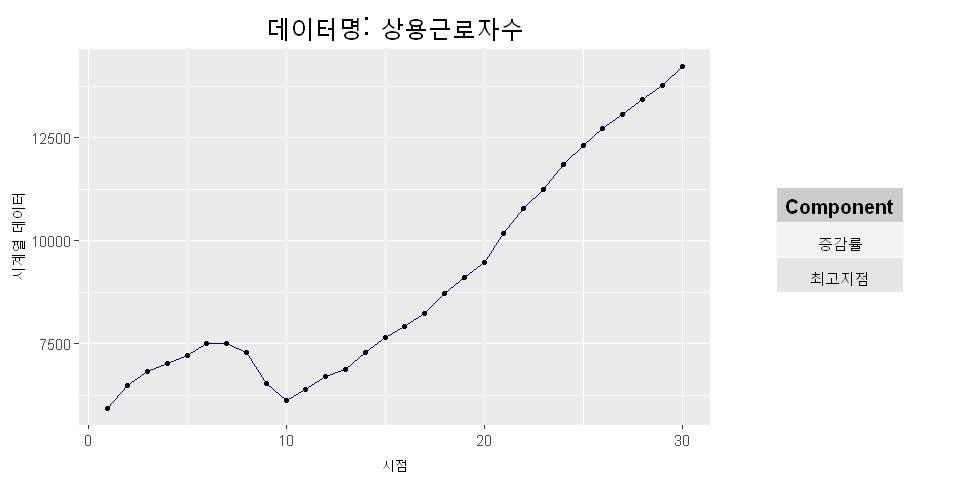

In [11]:
# 그래프 그리기 위해 raw data 정제하기
index <- c(1:length(excelData))
r_tst <- cbind(index, excelData)
r_tst <- as.data.frame(r_tst)
options(repr.plot.width=8, repr.plot.height=4)

# Raw data의 그래프 그리기 & 예측한 컴포넌트 나타내기
tst_plot <- ggplot(data = r_tst, aes(x = r_tst[, 1], y = r_tst[, 2])) + xlab("시점") + ylab('시계열 데이터') + geom_line(color = 'navy') + geom_point(size = 1)
pred_comp = data.frame(Component = pred_comp)
grid.arrange(tst_plot + ggtitle(paste('데이터명:', excelData_title)) + theme(plot.title = element_text(size = 20, hjust = 0.5)),
             tableGrob(pred_comp, rows = NULL), widths = c(3, 1))


# 모델링 ☞ ** 데이터의 대분류, 소분류, 주제분류 포함하는 경우 **

# 테스트 데이터 & 학습 데이터 정리

In [12]:
# 대분류, 소분류, 주제분류 입력받기
t(data.frame(대분류=c('보건/복지', '인구/가구', '고용/임금', '물가/가계', '사회', '경기/경영', '재정', '경제/금융', '교육/문화', '과학/환경', '에너지', '무역/수지')))
대분류 = readline('대분류 : ')
t(data.frame(소분류=c('실측값', '비율', '통계값', '지수')))
소분류 = readline('소분류 : ')
t(data.frame(주제분류=c('비율', '수', '금액', '지수', '수량', '기타')))
주제분류 = readline('주제분류 : ')

# 테스트 데이터 X변수 묶기
tst = data.frame(대분류, 소분류, 주제분류, avg_increase, previous_increase, mm, mmm, mmm_t, cv, p, slope, cpt_t, peakvalley, ARIMA_q, dw_t, wn_t, peak, pv_t, previous_differ)
tst = as.data.frame(tst)
colnames(tst) <- c('대분류', '소분류', '주제분류', '평균_증감률', '근시점_증감률', '최소최대', '절댓값_최소최대', '절댓값_최소최대_구간', '변동계수', '분위수_비율', '표준화_slope', 'ChangePoint_유무', 'PeakValley', 'ARIMA_차수', '자기상관_유의_유무', '백색잡음_유의_유무', 'Peak', 'PeakValley_구간', '근시점_차이')

# 데이터 행 이름 지정하기
rownames(tst) <- excelData_title

# 테스트 데이터의 factor 변수 numeric으로 형 변환하기
tst$대분류 <- as.numeric(tst$대분류)
tst$소분류 <- as.numeric(tst$소분류)
tst$주제분류 <- as.numeric(tst$주제분류)
tst$절댓값_최소최대_구간 <- as.numeric(tst$절댓값_최소최대_구간)
tst$ChangePoint_유무 <- as.numeric(tst$ChangePoint_유무)
tst$자기상관_유의_유무 <- as.numeric(tst$자기상관_유의_유무)
tst$백색잡음_유의_유무 <- as.numeric(tst$백색잡음_유의_유무)
tst$Peak <- as.numeric(tst$Peak)
tst$PeakValley_구간 <- as.numeric(tst$PeakValley_구간)




# 학습 데이터 가져오기
train <- read.csv("training_data.csv", header = TRUE)
train <- train[c(1:307), ]
train <- cbind(train[, c(1:20)], as.character(train[, 21]))
names(train)[21] <- "Check_Component"
train <- train[, -1]

# 학습 데이터의 factor 변수 numeric으로 형 변환하기
train$대분류 <- as.numeric(train$대분류)
train$소분류 <- as.numeric(train$소분류)
train$주제분류 <- as.numeric(train$주제분류)
train$절댓값_최소최대_구간 <- as.numeric(train$절댓값_최소최대_구간)
train$ChangePoint_유무 <- as.numeric(train$ChangePoint_유무)
train$자기상관_유의_유무 <- as.numeric(train$자기상관_유의_유무)
train$백색잡음_유의_유무 <- as.numeric(train$백색잡음_유의_유무)
train$Peak <- as.numeric(train$Peak)
train$PeakValley_구간 <- as.numeric(train$PeakValley_구간)
train$Check_Component <- as.character(train$Check_Component)


대분류,보건/복지,인구/가구,고용/임금,물가/가계,사회,경기/경영,재정,경제/금융,교육/문화,과학/환경,에너지,무역/수지


대분류 : 고용/임금


소분류,실측값,비율,통계값,지수


소분류 : 실측값


주제분류,비율,수,금액,지수,수량,기타


주제분류 : 수


# 모델링 -> 확률 추출

In [13]:

# 1번 증감률 컴포넌트 T/F 구하기
증감 <- ifelse(train$Check_Component == "1", "1", "0")
train_jeung <- cbind(train, 증감)
train_jeung <- train_jeung[, -20]

rf <- randomForest(증감 ~ 대분류 + 표준화_slope + PeakValley + PeakValley_구간, data = train_jeung, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_jeung <- pre[, 2]


# 9번 전시점비교 컴포넌트 T/F 구하기
전시점 <- ifelse(train$Check_Component == "9", "1", "0")
train_jeon <- cbind(train, 전시점)
train_jeon <- train_jeon[, -20]

rf <- randomForest(전시점 ~ ChangePoint_유무 + Peak + 근시점_증감률 + 최소최대 + 분위수_비율, data = train_jeon, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_jeon <- pre[, 2]


# 12번 최고지점 컴포넌트 T/F 구하기
최고지점 <- ifelse(train$Check_Component == "12", "1", "0")
train_choi <- cbind(train, 최고지점)
train_choi <- train_choi[, -20]

rf <- randomForest(최고지점 ~ 대분류 + 근시점_증감률 + 소분류 + ChangePoint_유무 + Peak+PeakValley + 근시점_차이, data = train_choi, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_choi <- pre[, 2]


# 13번 변곡점 컴포넌트 T/F 구하기
CP <- ifelse(train$Check_Component == "13", "1", "0")
train_CP <- cbind(train, CP)
train_CP <- train_CP[, -20]

rf <- randomForest(CP ~ Peak + 근시점_차이 + PeakValley_구간 + 표준화_slope + 최소최대, data = train_CP, importance = TRUE, ntree = 700, na.action = na.omit)
pre <- predict(rf, newdata = tst, type = "prob")
prob_CP <- pre[, 2]





# 각각에 해당할 확률 취합하기
prob <- cbind(prob_jeung, prob_jeon, prob_choi, prob_CP)
prob <- as.data.frame(prob)

# 각각의 확률값
prob2 <- data.frame(증감=prob[,1], 전시점=prob[,2], 최고지점=prob[,3], 변곡점=prob[,4])
prob2


증감,전시점,최고지점,변곡점
0.6214286,0.01142857,0.34,0.3542857


# 예측 컴포넌트 추출

In [14]:
# 각각의 cutoff 구하기

tmp <- nrow(subset(train, train$Check_Component == 1))
cutoff_jeung <- tmp / nrow(train)

tmp <- nrow(subset(train, train$Check_Component == 9))
cutoff_jeon <- tmp / nrow(train)

tmp <- nrow(subset(train, train$Check_Component == 12))
cutoff_choi <- tmp / nrow(train)

tmp <- nrow(subset(train, train$Check_Component == 13))
cutoff_CP <- tmp / nrow(train)


pred_comp <- c()

if(prob$prob_jeung >= cutoff_jeung) {
  pred_comp <- append(pred_comp, '증감률')
}

if(prob$prob_jeon >= cutoff_jeon) {
  pred_comp <- append(pred_comp, '전시점비교')
}

if(prob$prob_choi >= cutoff_choi) {
  pred_comp <- append(pred_comp, '최고지점')
}

if(prob$prob_CP >= cutoff_CP) {
  pred_comp <- append(pred_comp, '변곡점')
}

pred_comp <- as.vector(pred_comp)
paste('예측 컴포넌트 : ', pred_comp)

[1] "예측 컴포넌트 :  증감률"   "예측 컴포넌트 :  최고지점"
[3] "예측 컴포넌트 :  변곡점"

# 결과 plot

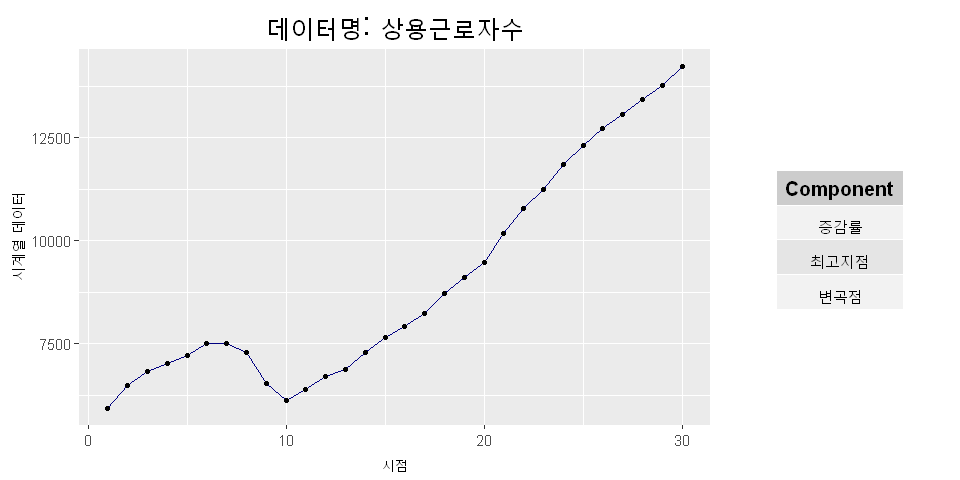

In [15]:
# 그래프 그리기 위해 raw data 정제하기
index <- c(1:length(excelData))
r_tst <- cbind(index, excelData)
r_tst <- as.data.frame(r_tst)
options(repr.plot.width=8, repr.plot.height=4)


# Raw data의 그래프 그리기 & 예측한 컴포넌트 나타내기
tst_plot <- ggplot(data = r_tst, aes(x = r_tst[, 1], y = r_tst[, 2])) + xlab("시점") + ylab('시계열 데이터') + geom_line(color = 'navy') + geom_point(size = 1)
pred_comp = data.frame(Component = pred_comp)
grid.arrange(tst_plot + ggtitle(paste('데이터명:', excelData_title)) + theme(plot.title = element_text(size = 20, hjust = 0.5)),
             tableGrob(pred_comp, rows = NULL), widths = c(3, 1))